In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import pingouin as pg
from matplotlib.colors import ListedColormap
pd.options.mode.chained_assignment = None

In [101]:
measurements = pd.read_excel(r'Z:\grodriguez\CardiacOCT\code\count-distributions\manual_vs_automatic_measures.xlsx', sheet_name='Calcium new test set')

## Functions

In [102]:
def get_data_filtered(test_sheet, type_manual, type_ai, missing = -99):

    manual = test_sheet[type_manual]

    ai = test_sheet[type_ai]

    list_fp = []
    list_fn = []
    list_nulls = []
    list_drops = []
    fp_count = 0
    fn_count = 0

    for value in range(len(manual)):

        if manual[value] == missing and ai[value] != missing:
            list_fp.append(value)
            fp_count += 1

        if manual[value] != missing and ai[value] == missing:
            list_fn.append(value)
            fn_count += 1

        if manual[value] == missing and ai[value] == missing:
            list_nulls.append(value)

        if ai[value] == np.nan:
            list_nulls.append(value)

    list_drops.extend(list_fp)
    list_drops.extend(list_fn)
    list_drops.extend(list_nulls)

    ai.drop(list_drops, inplace=True)
    manual.drop(list_drops, inplace=True)

    print('Found {} FP and {} FN. Total values are {}'.format(fp_count, fn_count, len(manual)))


    return manual, ai

In [103]:
def corr_plot(manual, automatic, thresh, title):

    print('Corr {}: {}'.format(title, np.corrcoef(manual, automatic)))

    col = []
    for i, j in zip(manual, automatic):
        if i <= thresh and j >= thresh:
            col.append(0)

        elif i >= thresh and j <= thresh:
            col.append(1)

        else:
            col.append(2)

    classes = ['FP', 'FN', 'TP/TN']
    if all(c == 2 for c in col):
        scatter = plt.scatter(manual, automatic, c='blue')
        plt.legend(handles=[scatter], labels=['TP/TN'])

    else:
        scatter = plt.scatter(manual, automatic, c=col, cmap=ListedColormap(['black', 'green', 'blue']))
        plt.axhline(thresh, color='r')
        plt.axvline(thresh, color='r')
        plt.xlabel('Manual')
        plt.ylabel('Automatic')
        plt.title(title)
        plt.legend(handles=scatter.legend_elements()[0], labels = classes)
        plt.show()

In [104]:
def calculate_icc(automatic_values, manual_values):

    raters1 = ['Automatic' for _ in range(len(automatic_values))]
    raters2 = ['Manual' for _ in range(len(automatic_values))]
    raters1.extend(raters2)

    exam1 = list(np.arange(0, len(automatic_values)))
    exam2 = list(np.arange(0, len(automatic_values)))
    exam1.extend(exam2)

    values_fct = pd.concat([automatic_values, manual_values])

    icc_df = pd.DataFrame({'exam': exam1, 'raters': raters1, 'fct': values_fct})

    icc = pg.intraclass_corr(icc_df, 'exam', 'raters', 'fct')

    return icc

# Bland Altman manual vs automatic

Found 9 FP and 5 FN. Total values are 23
70.20773927470015


Text(0.5, 1.0, 'Depth manual vs automatic')

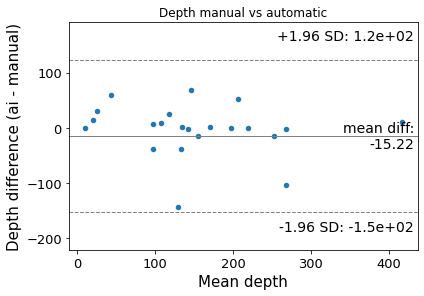

In [105]:
manual_depth, ai_depth_model3 = get_data_filtered(measurements, 'Depth test set', 'Depth model 1 2D')
mean = np.mean([manual_depth, ai_depth_model3], axis=0)
diff = manual_depth - ai_depth_model3                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_depth_model3, manual_depth, ax = axes)
plt.xlabel('Mean depth')
plt.ylabel('Depth difference (ai - manual)')
plt.title('Depth manual vs automatic')

Found 7 FP and 2 FN. Total values are 25
16.066661134162256


Text(0.5, 1.0, 'Calcium arc manual vs automatic')

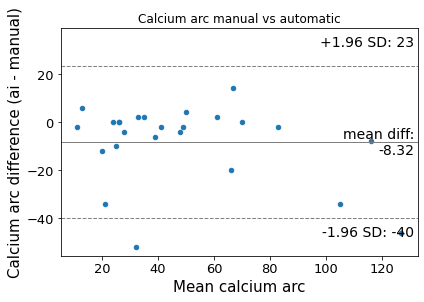

In [87]:
manual_arc, ai_arc_model3 = get_data_filtered(measurements, 'Arc test set', 'Arc model 3 2D')
mean = np.mean([manual_arc, ai_arc_model3], axis=0)
diff = manual_arc - ai_arc_model3                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)

fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_arc_model3, manual_arc, ax = axes)
plt.xlabel('Mean calcium arc')
plt.ylabel('Calcium arc difference (ai - manual)')
plt.title('Calcium arc manual vs automatic')


Found 7 FP and 2 FN. Total values are 25
164.0468030776583


Text(0.5, 1.0, 'Calcium thickness manual vs automatic')

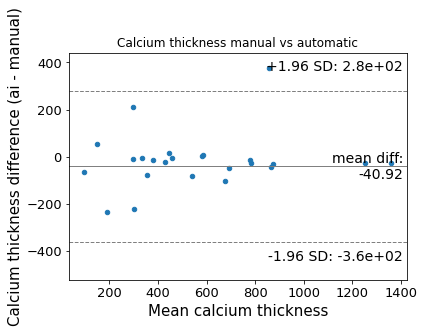

In [88]:
manual_thickness, ai_thickness_model3 = get_data_filtered(measurements, 'Thickness test set', 'Thickness model 3 2D')
mean = np.mean([manual_thickness, ai_thickness_model3], axis=0)
diff = manual_thickness - ai_thickness_model3                   
md = np.mean(diff)                   
sd = np.std(diff, axis=0) 
print(sd)


fig, axes = plt.subplots()

sm.graphics.mean_diff_plot(ai_thickness_model3, manual_thickness, ax = axes)
plt.xlabel('Mean calcium thickness')
plt.ylabel('Calcium thickness difference (ai - manual)')
plt.title('Calcium thickness manual vs automatic')

## Pearson and ICC

Corr Depth: [[1.         0.86816873]
 [0.86816873 1.        ]]


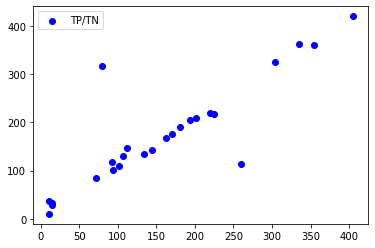

In [89]:
corr_plot(manual_depth, ai_depth_model3, 0, 'Depth')

Corr Calcium arc: [[1.         0.88416109]
 [0.88416109 1.        ]]


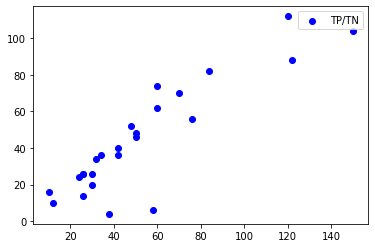

In [90]:
corr_plot(manual_arc, ai_arc_model3, 180, 'Calcium arc')

Corr Calcium thickness: [[1.         0.87133058]
 [0.87133058 1.        ]]


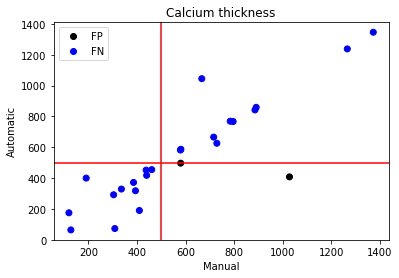

In [91]:
corr_plot(manual_thickness, ai_thickness_model3, 500, 'Calcium thickness')

In [92]:
calculate_icc(ai_depth_model3, manual_depth)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.865197,13.836446,24,25,3.245414e-09,"[0.72, 0.94]"
1,ICC2,Single random raters,0.865408,14.166018,24,24,4.583146e-09,"[0.72, 0.94]"
2,ICC3,Single fixed raters,0.868126,14.166018,24,24,4.583146e-09,"[0.72, 0.94]"
3,ICC1k,Average raters absolute,0.927727,13.836446,24,25,3.245414e-09,"[0.84, 0.97]"
4,ICC2k,Average random raters,0.927848,14.166018,24,24,4.583146e-09,"[0.84, 0.97]"
5,ICC3k,Average fixed raters,0.929409,14.166018,24,24,4.583146e-09,"[0.84, 0.97]"


In [93]:
calculate_icc(ai_arc_model3, manual_arc)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.848887,12.235134,24,25,1.228919e-08,"[0.69, 0.93]"
1,ICC2,Single random raters,0.850899,14.895473,24,24,2.694446e-09,"[0.65, 0.94]"
2,ICC3,Single fixed raters,0.874178,14.895473,24,24,2.694446e-09,"[0.74, 0.94]"
3,ICC1k,Average raters absolute,0.918268,12.235134,24,25,1.228919e-08,"[0.82, 0.96]"
4,ICC2k,Average random raters,0.919444,14.895473,24,24,2.694446e-09,"[0.79, 0.97]"
5,ICC3k,Average fixed raters,0.932866,14.895473,24,24,2.694446e-09,"[0.85, 0.97]"


In [94]:
calculate_icc(ai_thickness_model3, manual_thickness)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.868759,14.239101,24,25,2.371294e-09,"[0.73, 0.94]"
1,ICC2,Single random raters,0.868925,14.520067,24,24,3.531243e-09,"[0.73, 0.94]"
2,ICC3,Single fixed raters,0.871135,14.520067,24,24,3.531243e-09,"[0.73, 0.94]"
3,ICC1k,Average raters absolute,0.929771,14.239101,24,25,2.371294e-09,"[0.84, 0.97]"
4,ICC2k,Average random raters,0.929866,14.520067,24,24,3.531243e-09,"[0.84, 0.97]"
5,ICC3k,Average fixed raters,0.931130,14.520067,24,24,3.531243e-09,"[0.84, 0.97]"
